# ML Models on Letter Recognition UCI Dataset


## Data Description

The Letter Recognition dataset comprises 20,000 distinct black-and-white pixel display images, each representing one of the 26 capital letters of the English alphabet derived from 20 varied fonts. Each letter was uniquely distorted, and the resulting images were processed to extract 16 basic numerical features, including statistical moments and edge counts. These features were normalized to integer values ranging from 0 to 15.

## Data Source

https://archive.ics.uci.edu/dataset/59/letter+recognition


## Github Repository

https://github.com/jagrat89/LetterRecognition

## Imports

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

## EDA and Data Visualization

### Loading the Dataset

In [2]:
file_path = './letter-recognition.data'
column_names = ['letter', 'x-box', 'y-box', 'width', 'height', 'onpix', 'x-bar', 'y-bar', 'x2bar', 'y2bar', 
                'xybar', 'x2ybr', 'xy2br', 'x-ege', 'xegvy', 'y-ege', 'yegvx']

data = pd.read_csv(file_path, names=column_names)

data.head()

,letter,x-box,y-box,width,height,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10


- The first column __letter__ contains the target variable, which is the letter that each row's features represent.
- The following 16 columns are the features, which are all integer values representing various attributes of the letter's image.

### Summary Statistics on the Dataset

In [3]:
summary_statistics = data.describe()

missing_values = data.isnull().sum()

summary_statistics, missing_values

(              x-box         y-box         width       height         onpix  \
 count  20000.000000  20000.000000  20000.000000  20000.00000  20000.000000   
 mean       4.023550      7.035500      5.121850      5.37245      3.505850   
 std        1.913212      3.304555      2.014573      2.26139      2.190458   
 min        0.000000      0.000000      0.000000      0.00000      0.000000   
 25%        3.000000      5.000000      4.000000      4.00000      2.000000   
 50%        4.000000      7.000000      5.000000      6.00000      3.000000   
 75%        5.000000      9.000000      6.000000      7.00000      5.000000   
 max       15.000000     15.000000     15.000000     15.00000     15.000000   
 
               x-bar         y-bar         x2bar         y2bar         xybar  \
 count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
 mean       6.897600      7.500450      4.628600      5.178650      8.282050   
 std        2.026035      2.325354      2.69996

- All features range from 0 to 15, as discussed in the data description.
- The mean, standard deviation, and quartiles vary across different features, indicating diverse distributions.
- There are no missing values in any of the columns.

### Distribution of Features

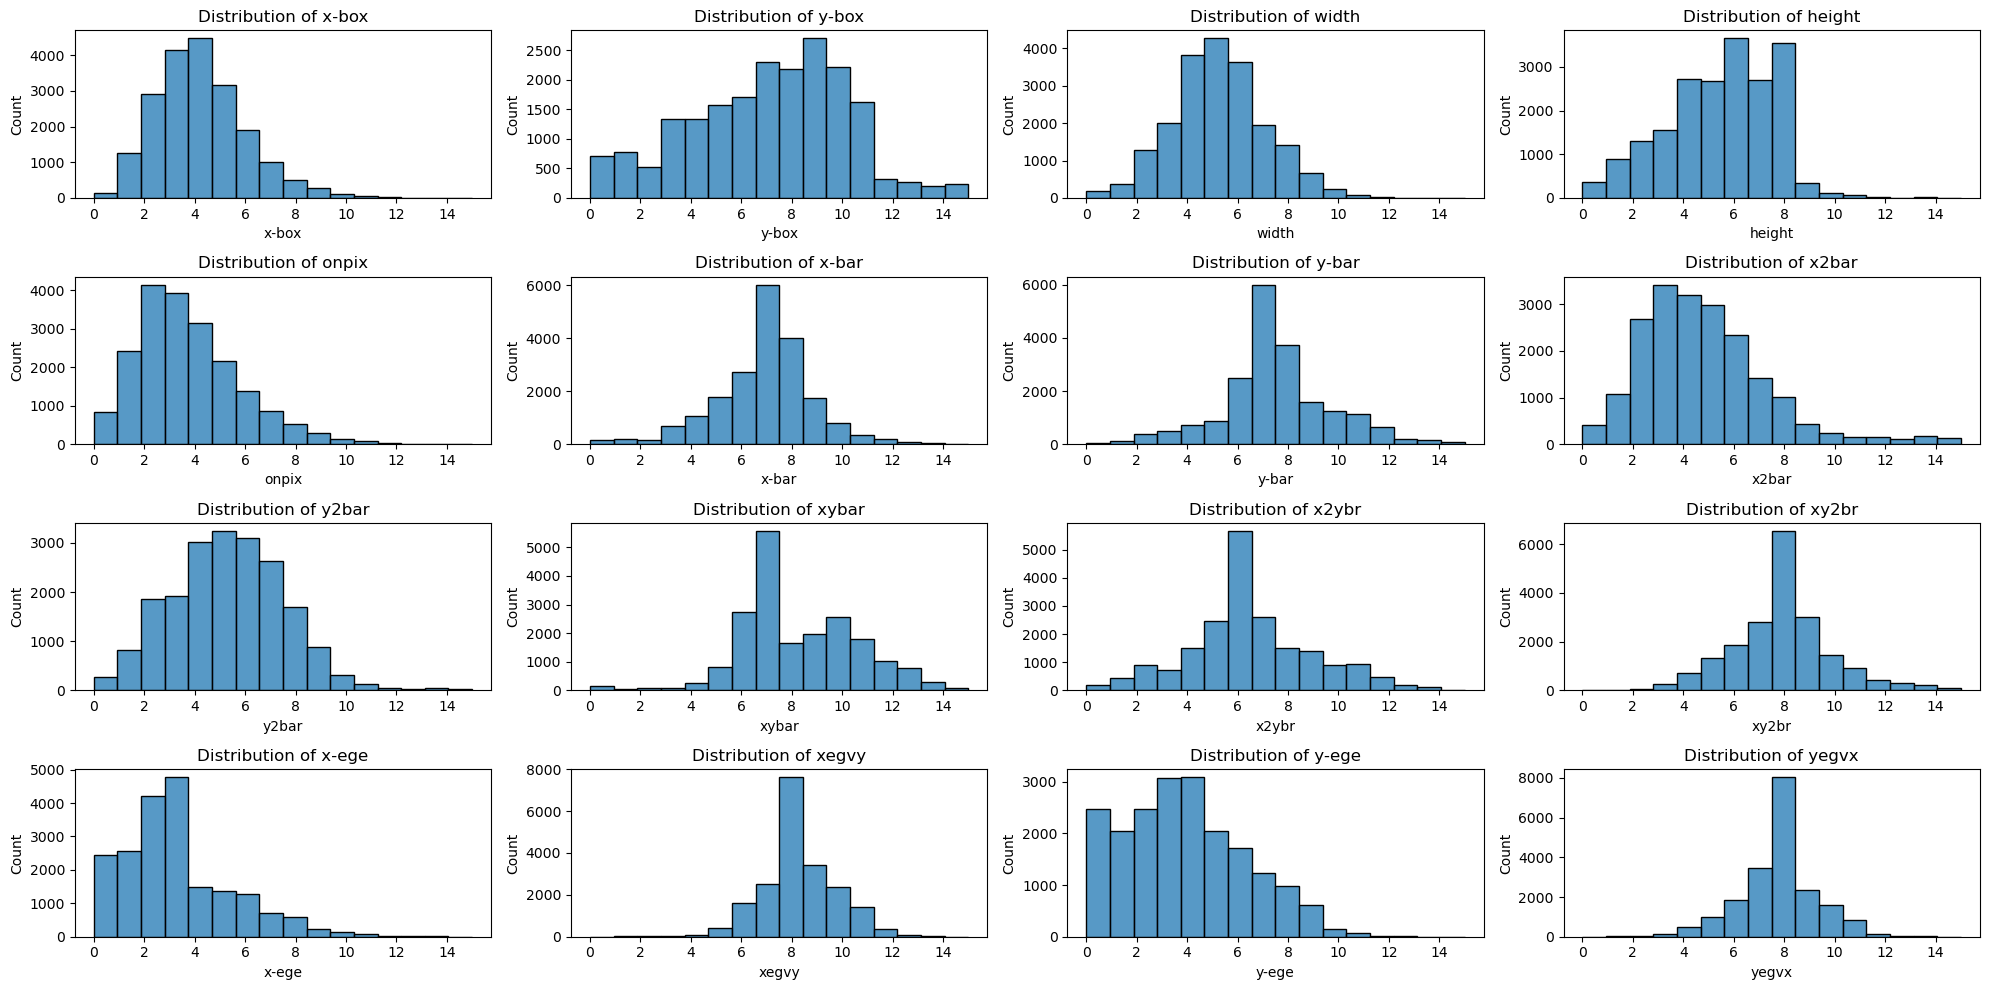

In [4]:
plt.figure(figsize=(20,10))

for index, feature in enumerate(column_names[1:], 1):
    plt.subplot(4, 4, index)
    sns.histplot(data[feature], bins=16, kde=False)
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

The histograms show the distribution of each feature across the dataset. Most features appear to have a roughly between normal or uniform distribution, although some skewness is noticeable in certain features.

### Boxplot of Features

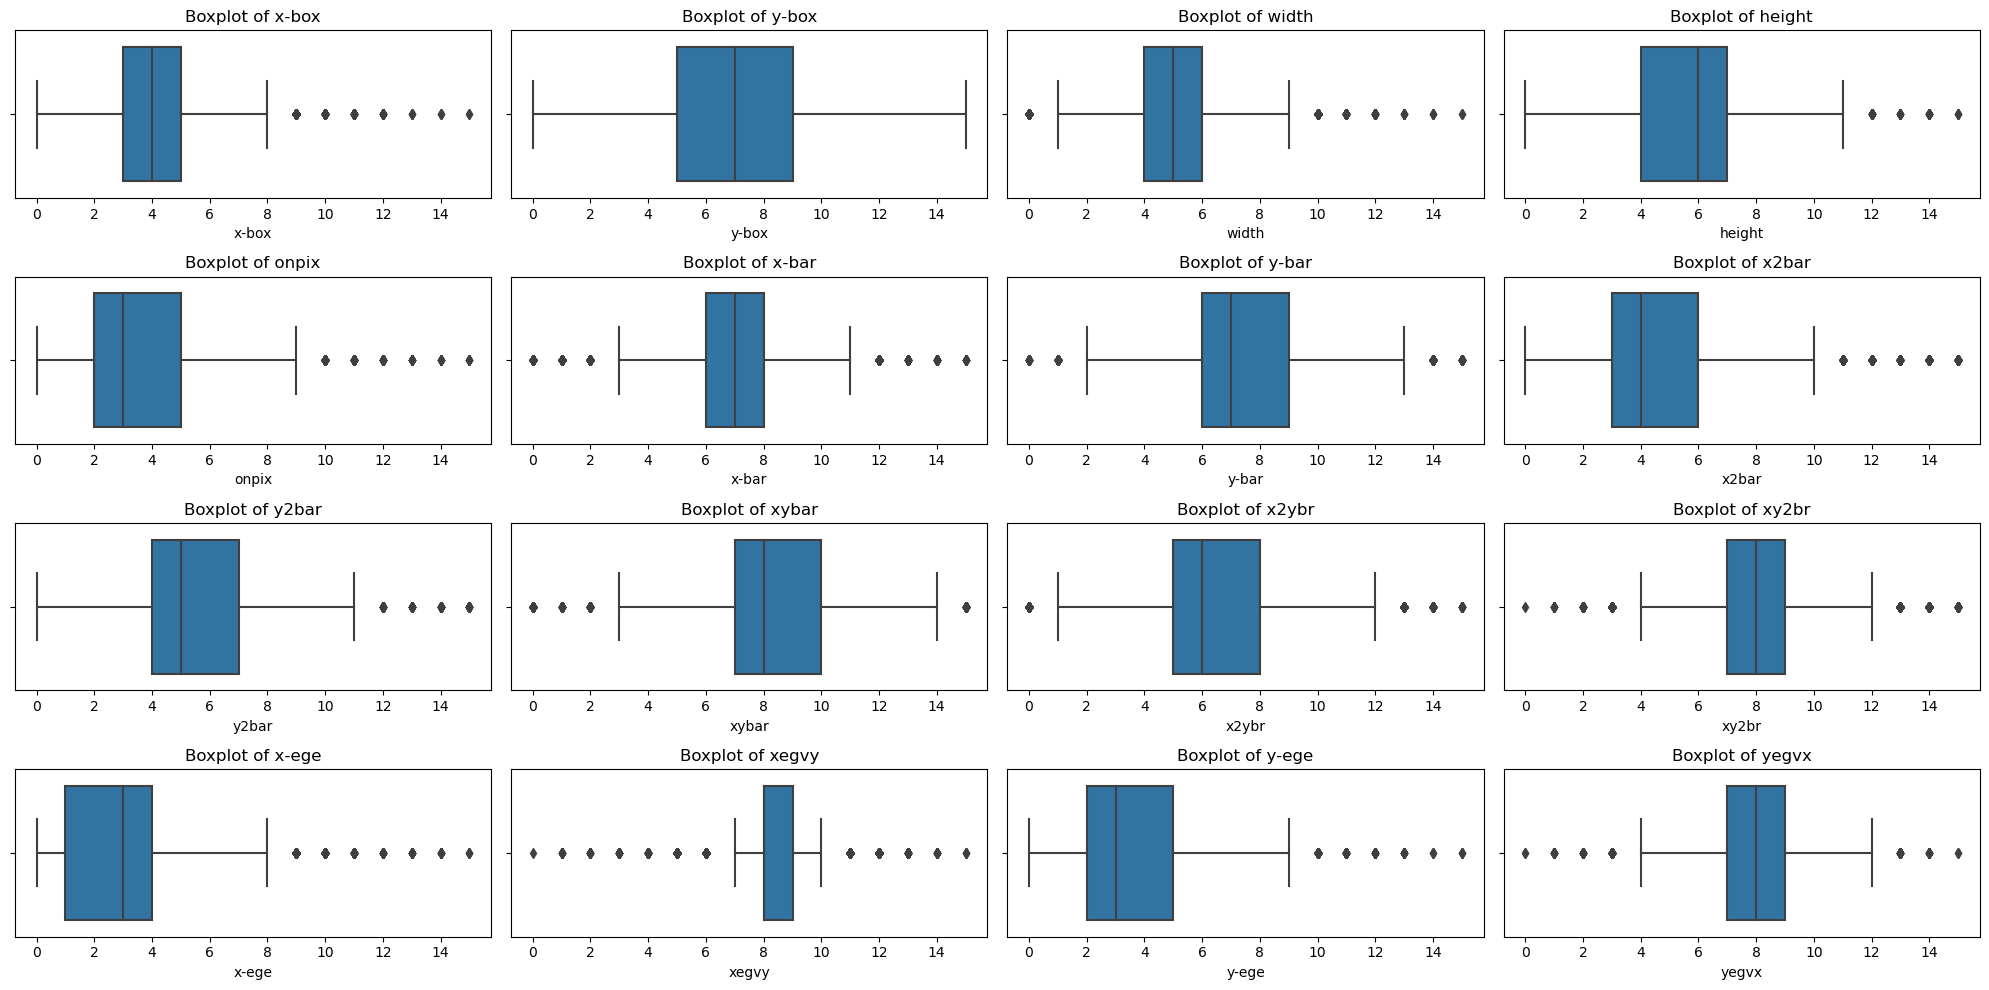

In [5]:
plt.figure(figsize=(20,10))

for index, feature in enumerate(column_names[1:], 1):
    plt.subplot(4, 4, index)
    sns.boxplot(x=data[feature])
    plt.title(f'Boxplot of {feature}')

plt.tight_layout()
plt.show()

- Some features have a number of outliers, as indicated by the points beyond the whiskers of the box plots.
- The interquartile range and median vary across different features.

### Distribution of Letters

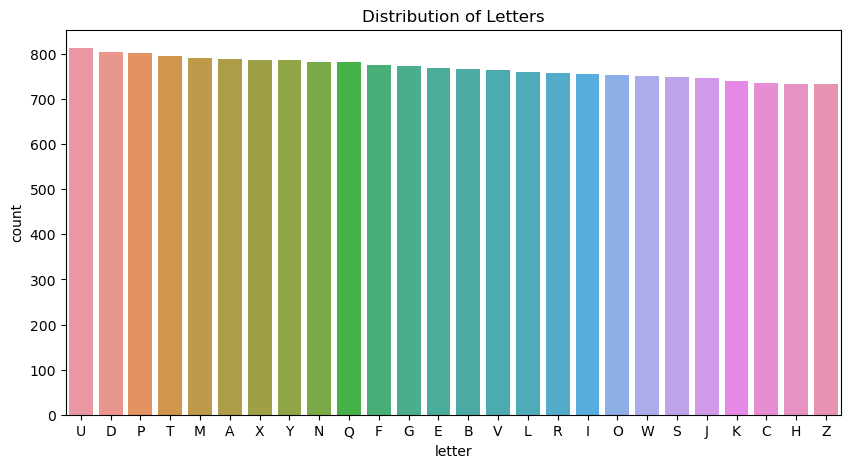

In [6]:
plt.figure(figsize=(10,5))
sns.countplot(data=data, x='letter', order = data['letter'].value_counts().index)
plt.title('Distribution of Letters')
plt.show()

The dataset seems to be fairly balanced with respect to the frequency of each letter.

### Correlation Heatmap of Features

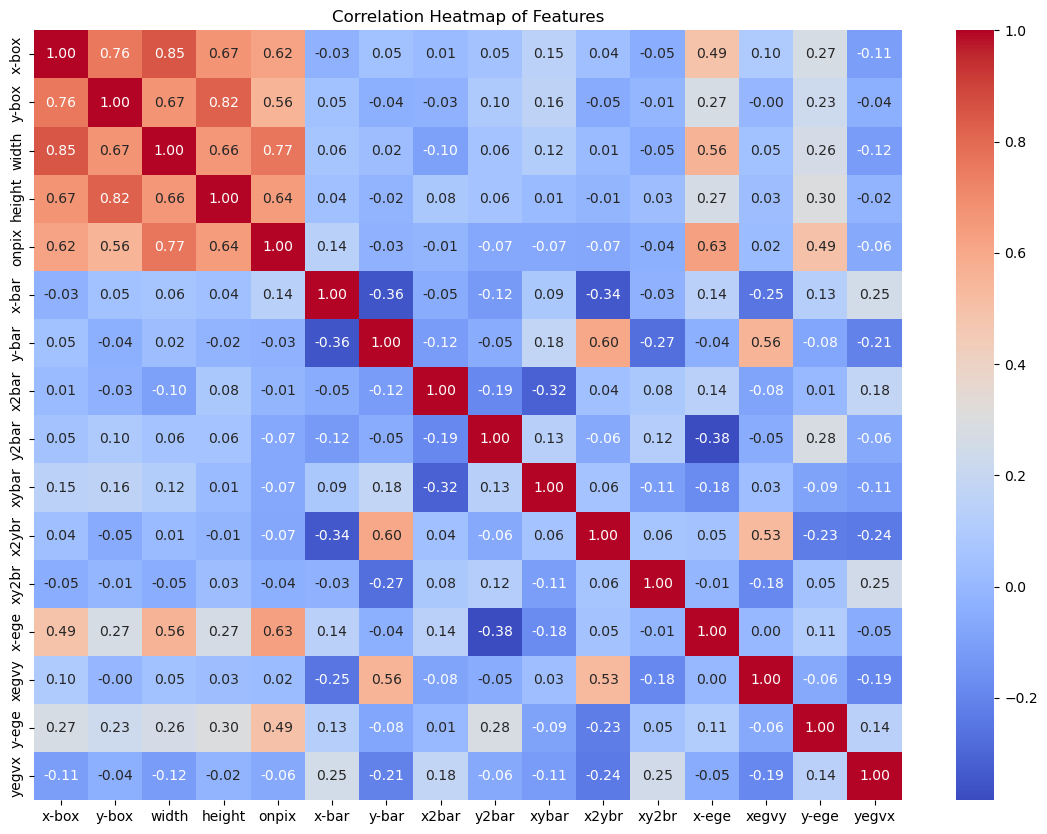

In [7]:
corr = data.iloc[:, 1:].corr()

plt.figure(figsize=(14, 10))

sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap of Features')
plt.show()

- Most features have low to moderate correlation with each other, suggesting that they contribute unique information.
- There are no extremely high correlations that would indicate redundancy between the features. The features onpix, height, width, y-box and x-box seem to have high correlation between each other becuase they represent similar concepts which are close to each other, but they do contribute unique characteristics to the dataset so I won't be removing them.

### Dimensionality Reduction

Next I will perform dimensionality reduction with PCA to visualize the dataset in two dimensions and see if there's any inherent clustering before proceeding to the modeling phase.

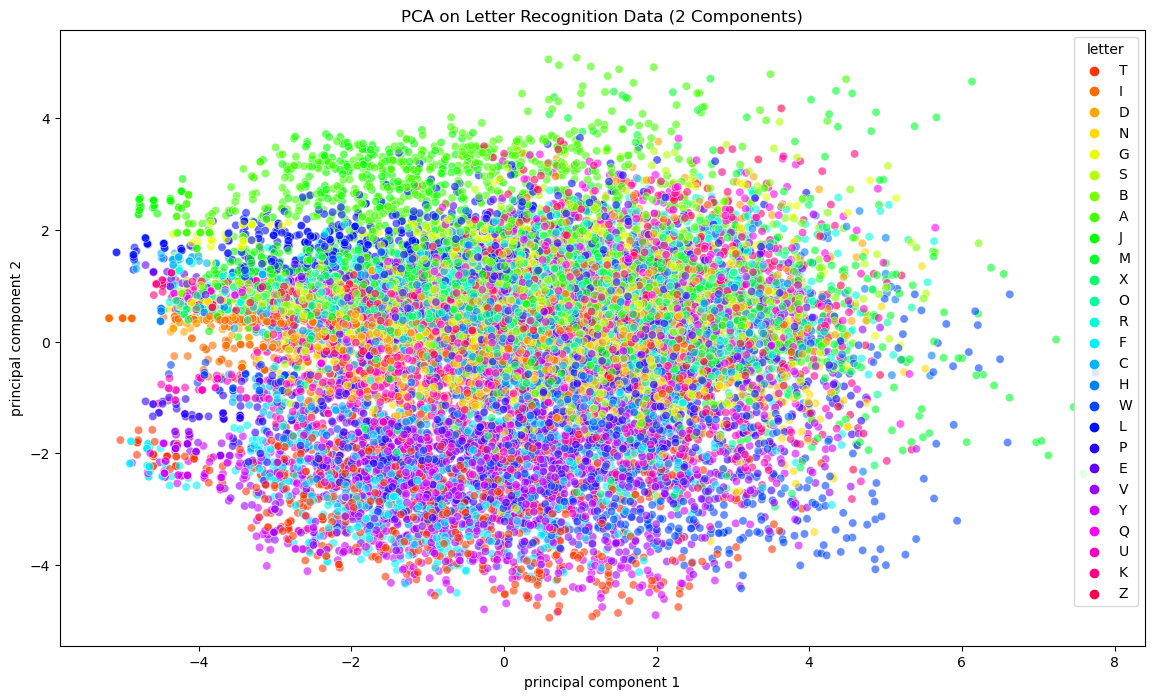

In [9]:
features = data.iloc[:, 1:]

features_standardized = StandardScaler().fit_transform(features)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features_standardized)

pca_df = pd.DataFrame(data=principalComponents, columns=['principal component 1', 'principal component 2'])

pca_df = pd.concat([pca_df, data[['letter']]], axis=1)

plt.figure(figsize=(14, 8))
sns.scatterplot(x="principal component 1", y="principal component 2", hue="letter", 
                palette=sns.color_palette("hsv", 26), data=pca_df, legend="full", alpha=0.6)
plt.title('PCA on Letter Recognition Data (2 Components)')
plt.show()

- The data points are spread out in the two-dimensional PCA space, but there is no clear separation into distinct clusters by letter. This suggests that the classification of letters based on these features is not trivial.
- While there are some groupings of the same letters, there is considerable overlap between different letters. This is expected given the complexity of the task and the reduction of feature space from 16 dimensions to 2.

## Modeling 

I will be training the following models:
- Unsupervised Learning:
  - K-Means Clustering
- Supervised Learning:
  - Support Vector Machine (SVM)
  - Random Forest Classifier

## Unsupervised Learning

### K-Means Clustering

I will set n_cluster = 26 because we have 26 letters. Once we have created the model I will plot the cluster centeroids on the PCA Plot form the EDA section to visualize the clusters.

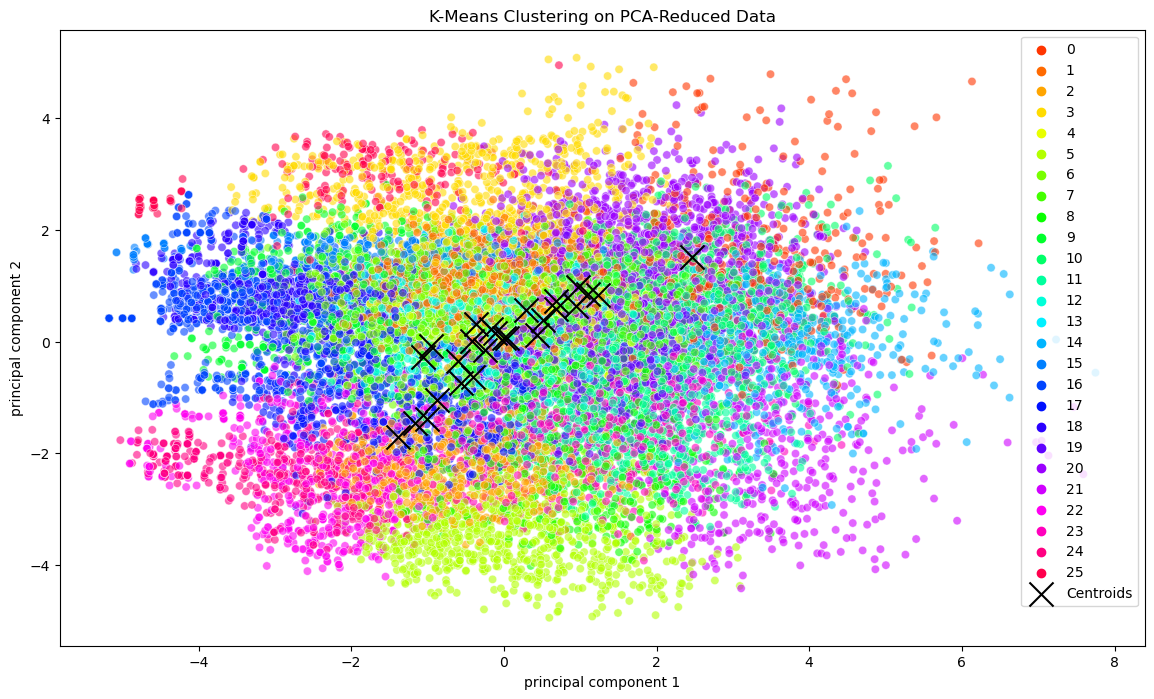

In [12]:
kmeans = KMeans(n_clusters=26, n_init=10, random_state=42)
kmeans.fit(features_standardized)

cluster_centers = kmeans.cluster_centers_
cluster_labels = kmeans.labels_

pca_df['kmeans_cluster'] = cluster_labels

plt.figure(figsize=(14, 8))
sns.scatterplot(x="principal component 1", y="principal component 2", hue='kmeans_cluster', 
                palette=sns.color_palette("hsv", 26), data=pca_df, legend="full", alpha=0.6)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=300, c='black', label='Centroids', marker='x')
plt.title('K-Means Clustering on PCA-Reduced Data')
plt.legend()
plt.show()

There is a lot of overlap between the clusters, which is an indication that Clustering might not be the most suited algorithm for this dataset.

#### Performance

I will calculate the Silhouette Score of the Cluster to see how well they are formed

In [14]:
full_silhouette_avg = silhouette_score(features_standardized, kmeans.labels_)

full_silhouette_avg

0.14384316732104954

The silhouette score for the K-Means clustering on the sample is approximately __14%__, which suggests that there is some structure to the clusters, but the overlap is significant, as the score is closer to 0 than to 1.

### Hypertuning $k (nclusters)$

I will use the elbow method to decide the optimal number of clusters, $k$, for the K-Means model. This is done by calculating the Within-Cluster Sum of Squares (WCSS) for different values of  $k$. The WCSS is the sum of squared distances between each point and the centroid of its assigned cluster. Typically, as $k$ increases, the WCSS will decrease because the points are closer to the centroids they are assigned to. The 'elbow' refers to the point where the WCSS begins to decrease more slowly, indicating a diminishing return on the explained variance. This point is considered a good trade-off between the number of clusters and the variance explained, and thus is chosen as the optimal $k$.

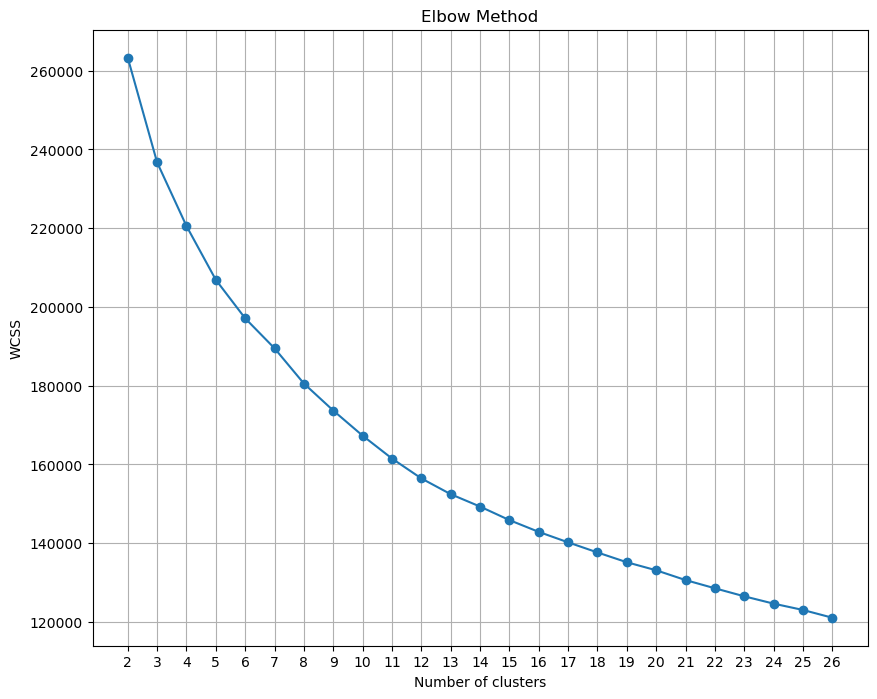

In [15]:
wcss = [] 
for i in range(2, 27):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features_standardized)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(2, 27), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  
plt.xticks(range(2, 27))
plt.grid(True)
plt.show()

From the plot, it appears that the curve begins to flatten after 
$k = 10$, but it's not a clear elbow as the WCSS continues to decrease at a somewhat steady rate. However, there seems to be a slight bend around 
$k = 15$ and another around  $k = 20$. 

Given that we have 26 letters, I will still choose  $k=26$, and there is no clear elbow in the above plot, and choosing 15 or 20 clusters doesn't make sense in terms of interpretability.

## Supervised Learning

Split the Data in Train and Test sets. I will use 80% of the data for training and the remaining 20% for testing

In [21]:
label_encoder = LabelEncoder()
data['letter'] = label_encoder.fit_transform(data['letter'])

X = data.drop('letter', axis=1) 
y = data['letter']          

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### SVM

Scaling the data for SVM.

In [22]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

Using GridSearch for finding the best Model. I will use diffrent Regulariation values for $C$ and use two diffrent values for the kernel coefficient which are 'scale' and 'auto'.  

In [23]:
param_grid = {
    'C': [0.1, 1, 10],  
    'gamma': ['scale', 'auto'],  
    'kernel': ['linear', 'rbf'] 
}

svm = SVC(random_state=42)

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search_svm.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=2)

#### Visualising the Results

I will create heat maps for each of the Kernels, 'linear' and 'rbf'.

/var/folders/0p/s6f8sz6x5b7bxc_7chgwyb600000gn/T/ipykernel_52743/1409452812.py:6: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  sns.heatmap(results_linear.pivot(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, fmt=".3f", cmap="viridis")


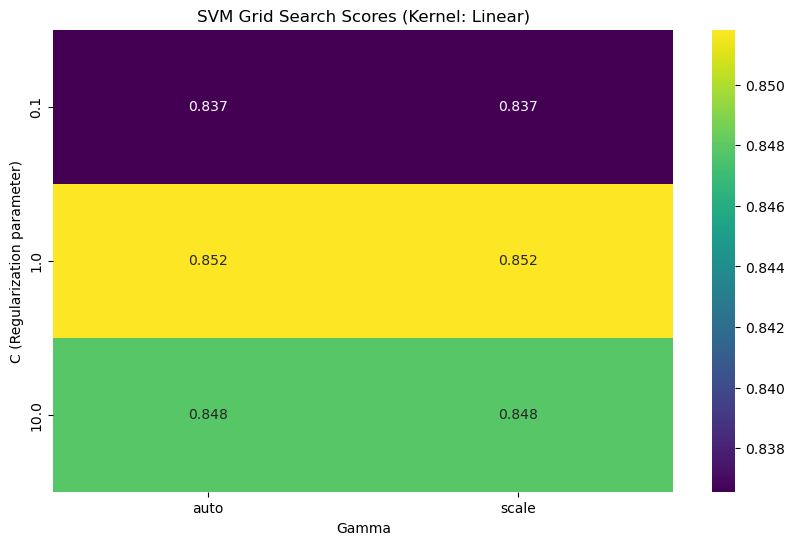

/var/folders/0p/s6f8sz6x5b7bxc_7chgwyb600000gn/T/ipykernel_52743/1409452812.py:14: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  sns.heatmap(results_rbf.pivot(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, fmt=".3f", cmap="viridis")


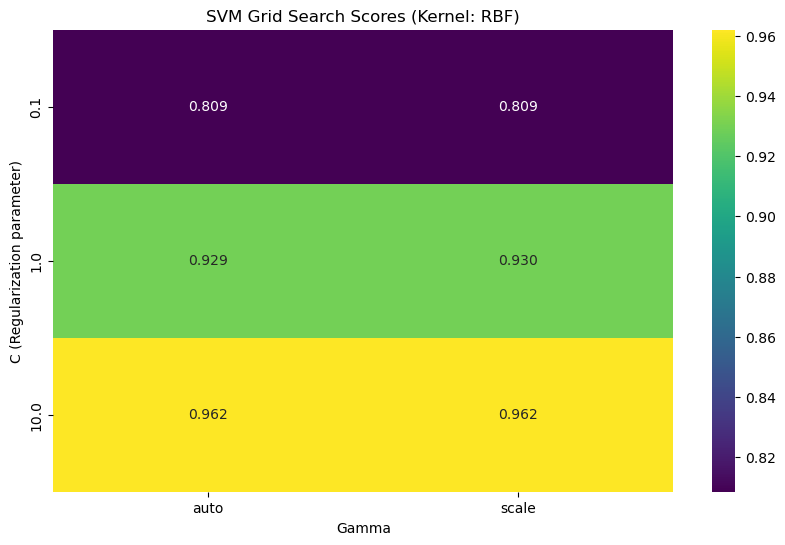

In [30]:
results = pd.DataFrame(grid_search_svm.cv_results_)


results_linear = results[results['param_kernel'] == 'linear']
plt.figure(figsize=(10, 6))
sns.heatmap(results_linear.pivot(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, fmt=".3f", cmap="viridis")
plt.title('SVM Grid Search Scores (Kernel: Linear)')
plt.xlabel('Gamma')
plt.ylabel('C (Regularization parameter)')
plt.show()

results_rbf = results[results['param_kernel'] == 'rbf']
plt.figure(figsize=(10, 6))
sns.heatmap(results_rbf.pivot(index='param_C', columns='param_gamma', values='mean_test_score'), annot=True, fmt=".3f", cmap="viridis")
plt.title('SVM Grid Search Scores (Kernel: RBF)')
plt.xlabel('Gamma')
plt.ylabel('C (Regularization parameter)')
plt.show()

The best mean test score is achieved with $C=10$, $gamma$='scale', and $kernel$='rbf'. This combination has a mean test score of approximately __96%__ on the training data, indicating a high level of accuracy across the cross-validation folds.

#### Test Scores of the Best Model

I will benchmark the best model on the test dataset.

Accuracy =  0.9755


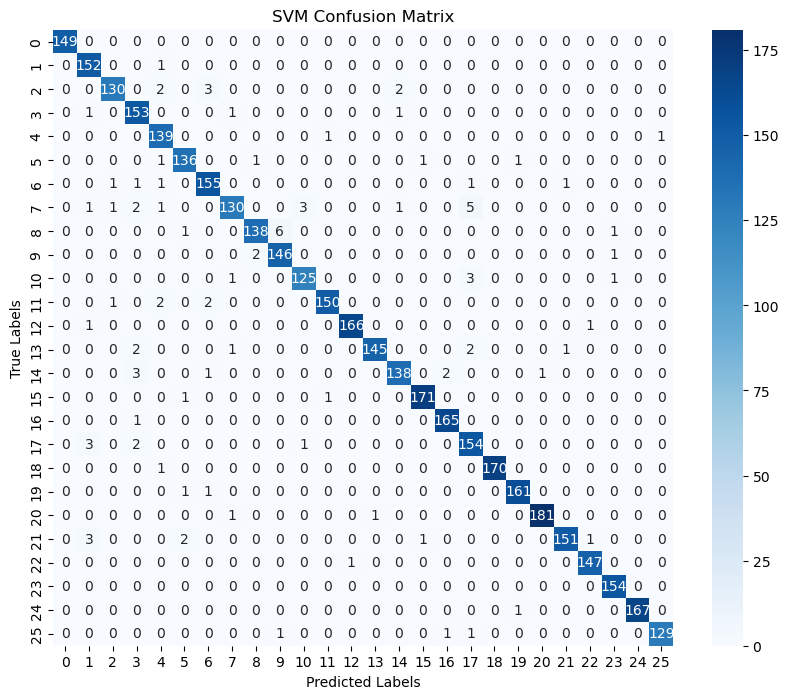

In [38]:
best_svm = grid_search_svm.best_estimator_

svm_predictions = best_svm.predict(X_test_scaled)

svm_accuracy = accuracy_score(y_test, svm_predictions)

svm_conf_matrix = confusion_matrix(y_test, svm_predictions)

print(f"Accuracy =  {svm_accuracy}")

plt.figure(figsize=(10, 8))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

From the above confusion matrix and accuracy score of __98%__ we can conclude that the SVM model with the __'rbf'__ kernel and __'scaled'__ kernel coefficient, with a regularization parameter __'C'__ = 10 is a highly accurate model for this classification task. Next I will train some other Supervised Models to see how they perform on the dataset. 

### Random Forest


First I will train a RF model with it's default settings and see how it fares on the test dataset.

Random Forest Accuracy =  0.961


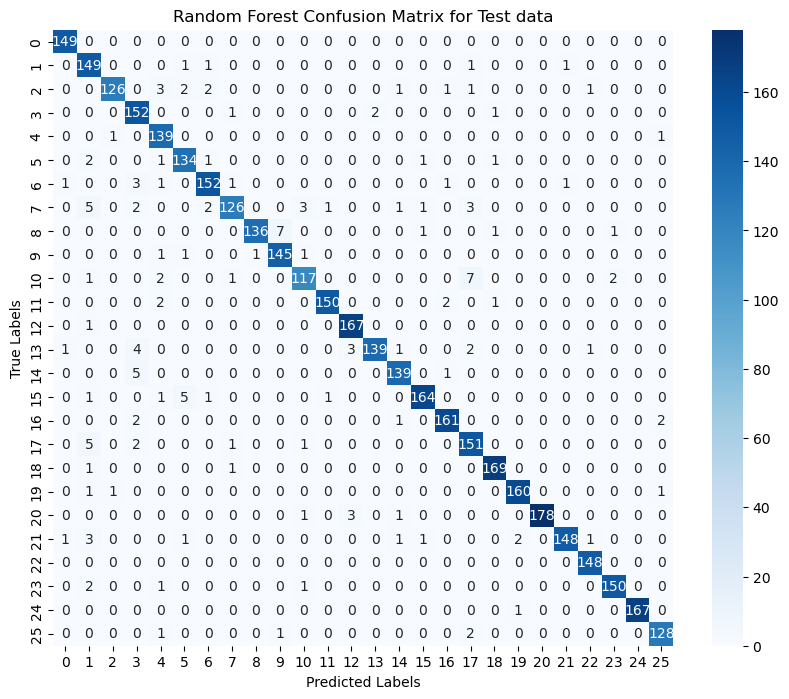

In [44]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

rf_predictions = rf.predict(X_test_scaled)

rf_accuracy = accuracy_score(y_test, rf_predictions)

rf_conf_matrix = confusion_matrix(y_test, rf_predictions)

print(f"Random Forest Accuracy =  {rf_accuracy}")

plt.figure(figsize=(10, 8))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

The defualt RF model with 100 estimators is already performing near as good as the SVM Model with a __96%__ test accuracy. Next I will try and hypertune it to see if it performs even better.

#### Hypertuning Random Forest

In [51]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.5s

/Users/jagratpatkar/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.7s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   2.3s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

#### Test Score of the Best Model

Best Model's Parameters:
{'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Best Model Train Accuracy =  0.9590002613821031
Best Model Test Accuracy =  0.966


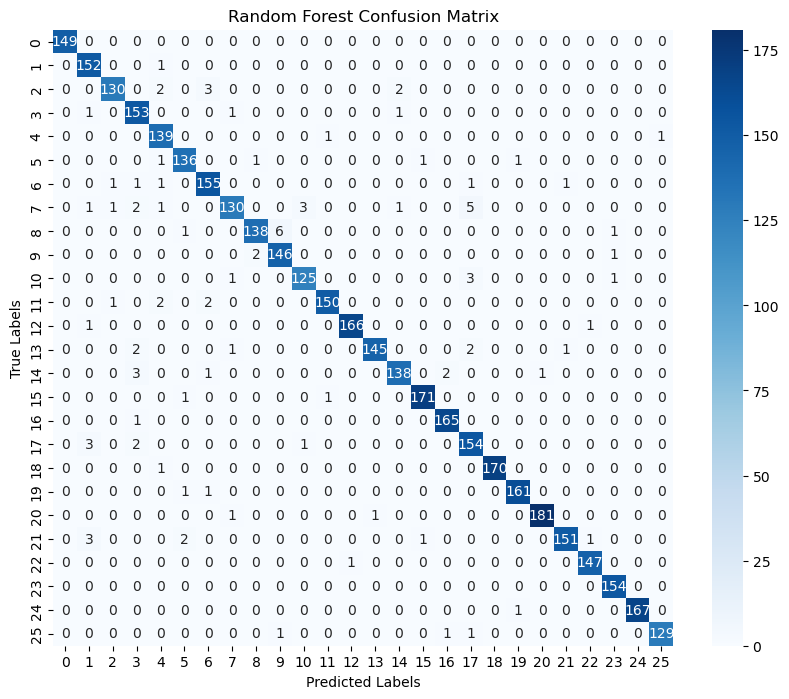

In [55]:
best_rf = grid_search.best_estimator_

print("Best Model's Parameters:")
print(best_rf.get_params())

rf_predictions = best_rf.predict(X_test_scaled)

rf_accuracy = accuracy_score(y_test, rf_predictions)

ht_rf_conf_matrix = confusion_matrix(y_test, rf_predictions)


print(f"Best Model Train Accuracy =  {grid_search.best_score_}")

print(f"Best Model Test Accuracy =  {rf_accuracy}")

plt.figure(figsize=(10, 8))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Analysis

After going through 162 different combinations of params, we find that the best estimator has a __1%__ higher score than the default RF model we tried which was __96%__ accuracy the best model has __97%__ accuracy for test data and a __96%__ accuracy on training data, the only difference is the number of estimators which in best model is __300__ and a max_depth of __30__. An accuracy of __97%__ is a very good for this classification task, and which is the same as the best SVM model.

### RF vs. SVM fit time comparison

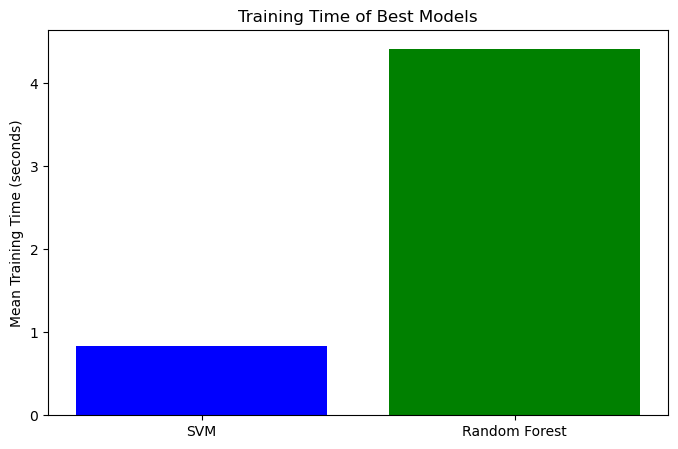

In [57]:
svm_train_time = grid_search_svm.cv_results_['mean_fit_time'][grid_search_svm.best_index_]
rf_train_time = grid_search.cv_results_['mean_fit_time'][grid_search.best_index_]

models = ['SVM', 'Random Forest']
times = [svm_train_time, rf_train_time]

plt.figure(figsize=(8, 5))
plt.bar(models, times, color=['blue', 'green'])
plt.ylabel('Mean Training Time (seconds)')
plt.title('Training Time of Best Models')
plt.show()

RF takes as much as 4x times fit time of SVM .

## Results and Conclusion

In this project, I trained and evaluated multiple models, focusing on both unsupervised and supervised learning approaches. The performance of the best models is summarized in the table below:

| Model | Silhouette Score | Train Acc | Test Acc |
|-------|------------------|-----------|----------|
| K-Means Clustering | 0.14 | - | - |
| SVM | - | 0.96 | 0.97 |
| Random Forest | - | 0.96 | 0.97 | 

The K-Means Clustering algorithm yielded a silhouette score of 0.14, which suggests a lack of distinct, well-separated clusters within the dataset. This indicates that the data may not be inherently grouped into well-defined clusters, or that K-Means was not the most suitable algorithm for this dataset due to its assumptions about cluster geometry. If we use it for classification by mapping the clusters to true labels it won't be very accurate because the clusters are overlapping.

For supervised learning, both the Support Vector Machine (SVM) and Random Forest models delivered high performance, showing similar accuracy on the training and test datasets. The SVM and Random Forest demonstrated accuracies of 96% and 97% on the training and test sets, respectively, after exhuastive hyperparameter tuning to determine the best model configurations. One notable difference between the models is the computational efficiency. The Random Forest model required approximately four times the amount of time to fit compared to the SVM. Given the similar accuracy levels but significantly higher computational cost, SVM emerges as the more resource-efficient choice between the two.

For future work, I could use Gradient Boosting Models and Neural Networks to benchmark their performance against the current models. These models could potentially offer improvements in predictive accuracy and might be more suited to capturing the complex relationships in the data. However, such advancements would also need to be weighed against increased computational demands and the complexity of tuning and interpretation